In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Bahia - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_BA.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Bahia - value,Bahia - Consumo de Cimento (t),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Bahia - IDH,Bahia - Produção de Cimento (t),Bahia - PIB - Estadual,Bahia - PIB - Construção Civil,Bahia - PIB - Per Capita,Bahia - PIB - Preços de Mercado,Bahia - Desemprego
0,2003-1,0.299858,151.297,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,0.669899,39.798880,1.317344e+08,8.384593e+06,8.566149,1.216359e+08,8.348779
1,2003-2,0.301903,138.707,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,0.670210,39.480034,1.318964e+08,8.391946e+06,8.569210,1.216914e+08,8.342979
2,2003-3,0.303709,135.009,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,0.670521,39.400256,1.320584e+08,8.399299e+06,8.572270,1.217469e+08,8.337179
3,2003-4,0.305311,126.554,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,0.670831,39.417185,1.322204e+08,8.406652e+06,8.575331,1.218023e+08,8.331379
4,2003-5,0.306860,137.331,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,0.671142,39.479943,1.323824e+08,8.414005e+06,8.578392,1.218578e+08,8.325579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,0.597113,366.305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.069163,NaN,NaN,NaN,NaN,NaN
236,2022-9,0.596178,346.042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.752943,NaN,NaN,NaN,NaN,NaN
237,2022-10,0.594662,347.901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.537361,NaN,NaN,NaN,NaN,NaN
238,2022-11,0.592436,310.845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.971241,NaN,NaN,NaN,NaN,NaN


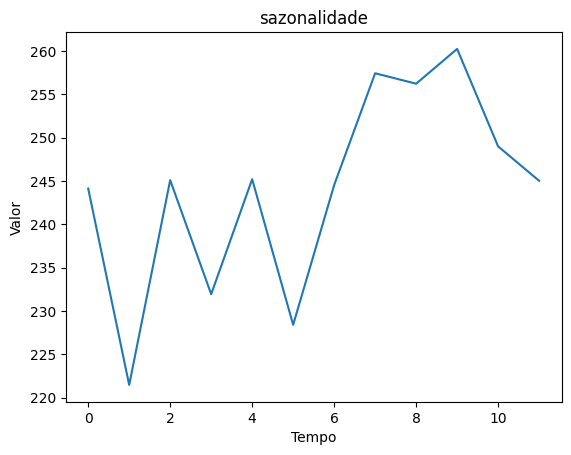

,sazonalidade
sazonalidade,
0,244.141607
1,221.458643
2,245.108143
3,231.937000
4,245.215857
5,228.399286
6,244.532929
7,257.450500
8,256.243786


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Bahia - value,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Bahia - IDH,Bahia - Produção de Cimento (t),Bahia - PIB - Estadual,Bahia - PIB - Construção Civil,Bahia - PIB - Per Capita,Bahia - PIB - Preços de Mercado,Bahia - Desemprego,sazonalidade,Bahia - Consumo de Cimento (t)
0,2003-1,0.299858,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,0.669899,39.798880,1.317344e+08,8.384593e+06,8.566149,1.216359e+08,8.348779,244.141607,151.297
1,2003-2,0.301903,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,0.670210,39.480034,1.318964e+08,8.391946e+06,8.569210,1.216914e+08,8.342979,221.458643,138.707
2,2003-3,0.303709,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,0.670521,39.400256,1.320584e+08,8.399299e+06,8.572270,1.217469e+08,8.337179,245.108143,135.009
3,2003-4,0.305311,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,0.670831,39.417185,1.322204e+08,8.406652e+06,8.575331,1.218023e+08,8.331379,231.937000,126.554
4,2003-5,0.306860,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,0.671142,39.479943,1.323824e+08,8.414005e+06,8.578392,1.218578e+08,8.325579,245.215857,137.331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,0.597113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.069163,NaN,NaN,NaN,NaN,NaN,257.450500,366.305
236,2022-9,0.596178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.752943,NaN,NaN,NaN,NaN,NaN,256.243786,346.042
237,2022-10,0.594662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.537361,NaN,NaN,NaN,NaN,NaN,260.261286,347.901
238,2022-11,0.592436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.971241,NaN,NaN,NaN,NaN,NaN,249.005714,310.845


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      139.997
1      111.865
2      159.603
3      142.063
4      137.144
        ...   
235        NaN
236        NaN
237        NaN
238        NaN
239        NaN
Name: Bahia - Consumo de Cimento (t), Length: 240, dtype: float64

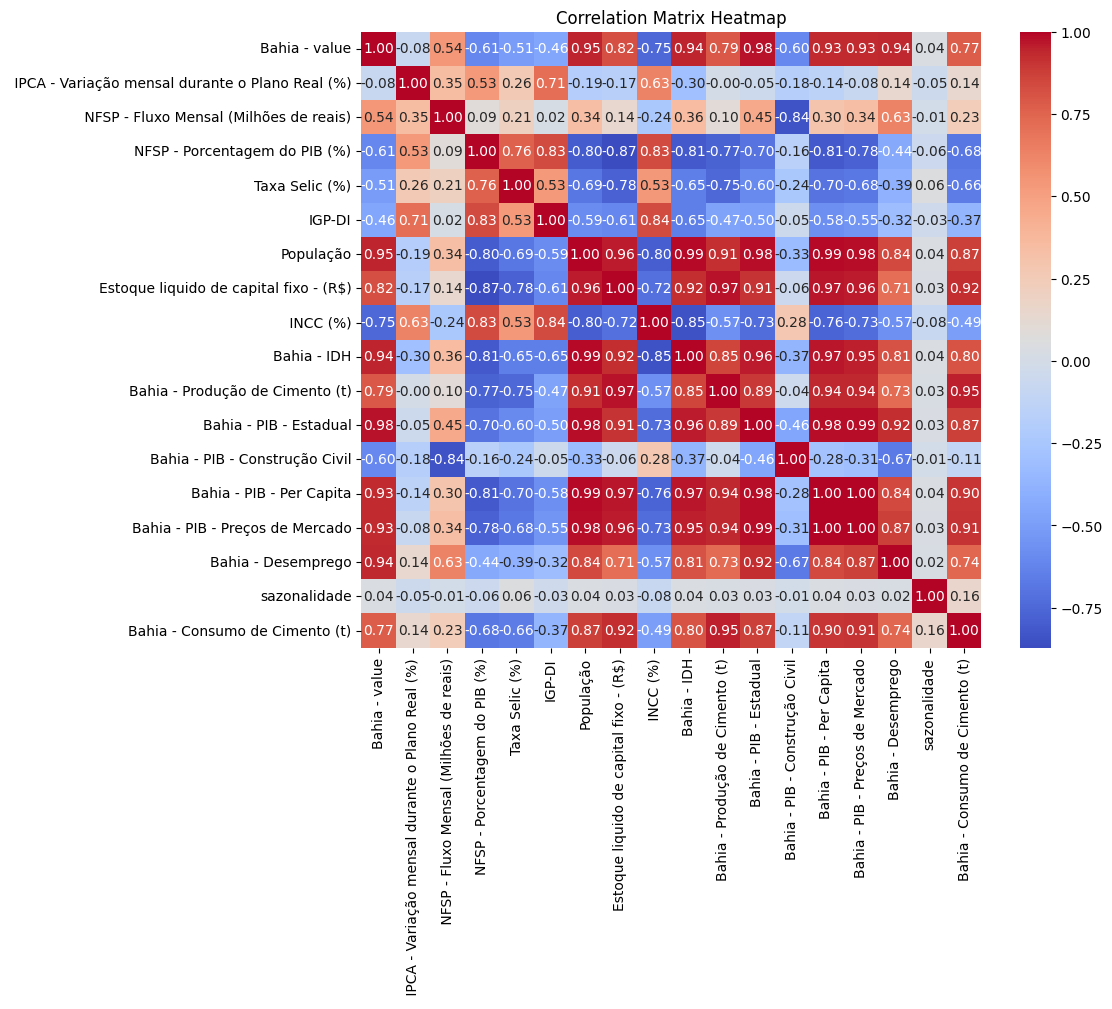

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Bahia - value,4.576342e+04
1,IPCA - Variação mensal durante o Plano Real (%),1.418646e+03
2,NFSP - Fluxo Mensal (Milhões de reais),3.082058e+02
3,NFSP - Porcentagem do PIB (%),1.958914e+02
4,Taxa Selic (%),5.966140e+01
5,IGP-DI,2.491431e+02
6,População,4.947764e+06
7,Estoque liquido de capital fixo - (R$),9.808870e+06
8,INCC (%),8.756189e+02
9,Bahia - IDH,1.624643e+06


In [39]:
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 4


,Bahia - value,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,INCC (%),Bahia - IDH,Bahia - Produção de Cimento (t),Bahia - PIB - Estadual,Bahia - PIB - Construção Civil,Bahia - Desemprego,sazonalidade
0,0.299858,0.724032,-5331.049150,11.520143,1.639718,1.036534,0.969649,0.669899,39.798880,1.317344e+08,8.384593e+06,8.348779,244.141607
1,0.301903,0.690297,-5318.079644,11.189862,1.378899,0.993449,0.950783,0.670210,39.480034,1.318964e+08,8.391946e+06,8.342979,221.458643
2,0.303709,0.669681,-5436.417870,10.820792,1.924317,0.973020,0.938332,0.670521,39.400256,1.320584e+08,8.399299e+06,8.337179,245.108143
3,0.305311,0.660494,-5707.015274,10.417840,1.331174,0.940489,0.926401,0.670831,39.417185,1.322204e+08,8.406652e+06,8.331379,231.937000
4,0.306860,0.648337,-5599.317941,9.959690,1.736072,0.917493,0.951683,0.671142,39.479943,1.323824e+08,8.414005e+06,8.325579,245.215857
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.476605,0.366904,-5783.316460,2.206994,0.545067,0.471521,0.378150,0.701139,91.995691,1.564800e+08,8.241231e+06,15.607881,257.450500
176,0.478697,0.358935,-6001.730740,2.215328,0.782910,0.476827,0.377666,0.701075,91.964124,1.564497e+08,8.240050e+06,15.604469,256.243786
177,0.480679,0.354313,-6454.887704,2.232466,0.909682,0.475427,0.377838,0.701011,92.171781,1.564195e+08,8.238870e+06,15.601056,260.261286
178,0.481471,0.352728,-6243.191421,2.263185,1.050614,0.491301,0.370057,0.700948,92.052788,1.563892e+08,8.237689e+06,15.597644,249.005714


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,INCC (%),Bahia - IDH,Bahia - Produção de Cimento (t),Bahia - PIB - Estadual,Bahia - PIB - Construção Civil,Bahia - Desemprego
0,2.802383,0.604311,4.268118,2.039314,3.921218,3.214079,-2.110321,-1.650237,-1.646879,-0.996444,-0.818821
1,2.402642,0.609431,4.096014,1.195209,3.582946,3.051841,-2.074685,-1.662829,-1.627694,-0.949829,-0.820524
2,2.158351,0.562720,3.903698,2.960381,3.422548,2.944772,-2.039049,-1.665979,-1.608509,-0.903215,-0.822226
3,2.049492,0.455907,3.693727,1.040752,3.167136,2.842174,-2.003412,-1.665311,-1.589324,-0.856600,-0.823929
4,1.905441,0.498418,3.454992,2.351150,2.986591,3.059587,-1.967776,-1.662832,-1.570138,-0.809986,-0.825632
...,...,...,...,...,...,...,...,...,...,...,...
175,-1.429358,0.425789,-0.584804,-1.503380,-0.514871,-1.872446,1.472788,0.411133,1.283512,-1.905278,1.312242
176,-1.523783,0.339575,-0.580461,-0.733634,-0.473208,-1.876611,1.465476,0.409887,1.279927,-1.912764,1.311240
177,-1.578548,0.160702,-0.571531,-0.323353,-0.484199,-1.875135,1.458164,0.418087,1.276342,-1.920249,1.310238
178,-1.597335,0.244264,-0.555524,0.132757,-0.359568,-1.942040,1.450853,0.413388,1.272758,-1.927734,1.309236


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,INCC (%),Bahia - IDH,Bahia - Produção de Cimento (t),Bahia - PIB - Estadual,Bahia - PIB - Construção Civil,Bahia - Desemprego
0,2.802383,0.604311,4.268118,2.039314,3.921218,3.214079,-2.110321,-1.650237,-1.646879,-0.996444,-0.818821
1,2.402642,0.609431,4.096014,1.195209,3.582946,3.051841,-2.074685,-1.662829,-1.627694,-0.949829,-0.820524
2,2.158351,0.562720,3.903698,2.960381,3.422548,2.944772,-2.039049,-1.665979,-1.608509,-0.903215,-0.822226
3,2.049492,0.455907,3.693727,1.040752,3.167136,2.842174,-2.003412,-1.665311,-1.589324,-0.856600,-0.823929
4,1.905441,0.498418,3.454992,2.351150,2.986591,3.059587,-1.967776,-1.662832,-1.570138,-0.809986,-0.825632
...,...,...,...,...,...,...,...,...,...,...,...
163,-0.960452,1.465326,-0.676734,0.472779,-1.087000,-1.491033,1.537570,0.515788,1.301773,-1.715474,1.346223
164,-1.007966,1.351131,-0.668750,0.302784,-0.904679,-1.525186,1.534850,0.503986,1.303139,-1.742955,1.340829
165,-0.976556,1.143146,-0.657609,0.339539,-0.900134,-1.546744,1.532130,0.501383,1.304505,-1.770437,1.335435
166,-1.146834,1.542609,-0.647588,0.472795,-1.136836,-1.586381,1.529410,0.493451,1.305871,-1.797918,1.330042


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      139.997
1      111.865
2      159.603
3      142.063
4      137.144
        ...   
163    292.688
164    258.881
165    276.879
166    255.774
167    208.326
Name: Bahia - Consumo de Cimento (t), Length: 168, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 11)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,INCC (%),Bahia - IDH,Bahia - Produção de Cimento (t),Bahia - PIB - Estadual,Bahia - PIB - Construção Civil,Bahia - Desemprego
132,1.530065,0.817451,-0.366715,-0.530011,0.174628,-0.066954,0.620351,1.089633,1.036921,-0.213487,1.163784
133,1.649361,1.130195,-0.350285,-0.532694,0.240832,-0.130652,0.620117,1.075078,1.051129,-0.275738,1.177052
134,1.622916,1.160498,-0.335122,-0.186421,0.176857,-0.079602,0.619884,1.061504,1.065336,-0.337988,1.190321
135,1.581460,1.131990,-0.321950,-0.719664,-0.005233,-0.034473,0.619650,1.047242,1.079543,-0.400239,1.203589
136,1.638292,1.384387,-0.302995,-0.798520,0.097576,-0.177535,0.619417,1.032520,1.093751,-0.462489,1.216857
137,1.643773,1.375487,-0.290554,-0.612129,0.431487,-0.208868,0.619183,1.017173,1.107958,-0.524740,1.230126
138,1.704584,1.438928,-0.281926,-0.476740,0.482414,-0.245300,0.618950,1.001228,1.122166,-0.586991,1.243394
139,1.841703,1.569590,-0.275931,-0.211736,0.657043,-0.333490,0.618716,0.984640,1.136373,-0.649241,1.256663
140,1.837218,1.584058,-0.271466,-0.484608,0.678386,-0.296846,0.618483,0.967535,1.150581,-0.711492,1.269931
141,1.797860,1.166380,-0.273241,-0.183907,0.727143,-0.292462,0.618250,0.949944,1.164788,-0.773742,1.283200


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 11)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[3473350141, 2836520374, 2618701422, 3162503587, 4019820030, 1968516828, 1468778738, 2185154754, 1351941448, 1412298297]


Step: 0 ___________________________________________
val_loss: 17507678.0
winner_seed: 3473350141


Step: 1 ___________________________________________
val_loss: 572.6707153320312
winner_seed: 2836520374


Step: 2 ___________________________________________
val_loss: 893.8594970703125


Step: 3 ___________________________________________
val_loss: 922.7734375


Step: 4 ___________________________________________
val_loss: 859.6319580078125


Step: 5 ___________________________________________
val_loss: 1046.6568603515625


Step: 6 ___________________________________________
val_loss: 751.3582153320312


Step: 7 ___________________________________________
val_loss: 954.9190673828125


Step: 8 ___________________________________________
val_loss: 149729069498368.0


Step: 9 ___________________________________________
val_loss: 1468.65185546875


final_seed: 2836520374

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 2536234443

Epoch 1/10000
4/4 [==============================] - 2s 244ms/step - loss: 56569.2812 - val_loss: 3615.4329
Epoch 2/10000
4/4 [==============================] - 0s 8ms/step - loss: 2171.3123 - val_loss: 2852.4070
Epoch 3/10000
4/4 [==============================] - 0s 7ms/step - loss: 2164.8936 - val_loss: 2170.2656
Epoch 4/10000
4/4 [==============================] - 0s 7ms/step - loss: 2193.5962 - val_loss: 1458.5397
Epoch 5/10000
4/4 [==============================] - 0s 7ms/step - loss: 2114.6973 - val_loss: 3658.8059
Epoch 6/10000
4/4 [==============================] - 0s 7ms/step - loss: 2343.5732 - val_loss: 2350.3430
Epoch 7/10000
4/4 [==============================] - 0s 7ms/step - loss: 2105.3054 - val_loss: 3418.8657
Epoch 8/10000
4/4 [==============================] - 0s 7ms/step - loss: 2277.1304 - val_loss: 2699.3313
Epoch 9/10000
4/4 [==============================] - 0s 7ms/step - loss: 2134.4131 - val_loss: 2358.7529
Epoch 10/10000
4/4 [==============================] 

4/4 [==============================] - 0s 8ms/step - loss: 397.0112 - val_loss: 844.2596
Epoch 80/10000
4/4 [==============================] - 0s 7ms/step - loss: 322.0708 - val_loss: 866.0350
Epoch 81/10000
4/4 [==============================] - 0s 7ms/step - loss: 393.1983 - val_loss: 880.9115
Epoch 82/10000
4/4 [==============================] - 0s 7ms/step - loss: 399.4355 - val_loss: 915.4603
Epoch 83/10000
4/4 [==============================] - 0s 7ms/step - loss: 394.0614 - val_loss: 849.2596
Epoch 84/10000
4/4 [==============================] - 0s 7ms/step - loss: 394.1901 - val_loss: 879.7120
Epoch 85/10000
4/4 [==============================] - 0s 7ms/step - loss: 431.0568 - val_loss: 1022.6768
Epoch 86/10000
4/4 [==============================] - 0s 7ms/step - loss: 340.2058 - val_loss: 810.2377
Epoch 87/10000
4/4 [==============================] - 0s 7ms/step - loss: 349.6255 - val_loss: 903.0475
Epoch 88/10000
4/4 [==============================] - 0s 7ms/step - loss: 324.

4/4 [==============================] - 0s 7ms/step - loss: 273.1269 - val_loss: 867.5554
Epoch 158/10000
4/4 [==============================] - 0s 7ms/step - loss: 267.1200 - val_loss: 880.6369
Epoch 159/10000
4/4 [==============================] - 0s 7ms/step - loss: 266.1731 - val_loss: 914.0684
Epoch 160/10000
4/4 [==============================] - 0s 8ms/step - loss: 288.8573 - val_loss: 984.7264
Epoch 161/10000
4/4 [==============================] - 0s 7ms/step - loss: 269.9232 - val_loss: 962.5624
Epoch 162/10000
4/4 [==============================] - 0s 7ms/step - loss: 269.7300 - val_loss: 1013.5099
Epoch 163/10000
4/4 [==============================] - 0s 7ms/step - loss: 264.5461 - val_loss: 999.8693
Epoch 164/10000
4/4 [==============================] - 0s 7ms/step - loss: 297.5197 - val_loss: 872.9683
Epoch 165/10000
4/4 [==============================] - 0s 7ms/step - loss: 295.7255 - val_loss: 988.9884
Epoch 166/10000
4/4 [==============================] - 0s 7ms/step - l

4/4 [==============================] - 0s 7ms/step - loss: 276.4057 - val_loss: 1029.5463
Epoch 236/10000
4/4 [==============================] - 0s 7ms/step - loss: 258.0157 - val_loss: 922.6452
Epoch 237/10000
4/4 [==============================] - 0s 7ms/step - loss: 255.6410 - val_loss: 896.2626
Epoch 238/10000
4/4 [==============================] - 0s 7ms/step - loss: 233.6342 - val_loss: 912.4684
Epoch 239/10000
4/4 [==============================] - 0s 7ms/step - loss: 241.4050 - val_loss: 910.0099
Epoch 240/10000
4/4 [==============================] - 0s 7ms/step - loss: 318.3386 - val_loss: 908.9539
Epoch 241/10000
4/4 [==============================] - 0s 7ms/step - loss: 234.2540 - val_loss: 934.2336
Epoch 242/10000
4/4 [==============================] - 0s 7ms/step - loss: 231.8304 - val_loss: 958.4084
Epoch 243/10000
4/4 [==============================] - 0s 7ms/step - loss: 230.7976 - val_loss: 1063.7404
Epoch 244/10000
4/4 [==============================] - 0s 7ms/step - 

Epoch 313/10000
4/4 [==============================] - 0s 7ms/step - loss: 205.5706 - val_loss: 1048.2104
Epoch 314/10000
4/4 [==============================] - 0s 8ms/step - loss: 207.1548 - val_loss: 1080.3591
Epoch 315/10000
4/4 [==============================] - 0s 7ms/step - loss: 207.3410 - val_loss: 1007.4803
Epoch 316/10000
4/4 [==============================] - 0s 7ms/step - loss: 209.6155 - val_loss: 962.1526
Epoch 317/10000
4/4 [==============================] - 0s 7ms/step - loss: 256.6325 - val_loss: 1069.3312
Epoch 318/10000
4/4 [==============================] - 0s 7ms/step - loss: 226.3444 - val_loss: 1003.4962
Epoch 319/10000
4/4 [==============================] - 0s 7ms/step - loss: 257.2919 - val_loss: 1290.2236
Epoch 320/10000
4/4 [==============================] - 0s 7ms/step - loss: 266.7004 - val_loss: 1223.6550
Epoch 321/10000
4/4 [==============================] - 0s 7ms/step - loss: 251.7829 - val_loss: 989.3904
Epoch 322/10000
4/4 [===========================

4/4 [==============================] - 0s 8ms/step - loss: 315.5758 - val_loss: 902.7586
Epoch 391/10000
4/4 [==============================] - 0s 7ms/step - loss: 313.0116 - val_loss: 872.8177
Epoch 392/10000
4/4 [==============================] - 0s 7ms/step - loss: 307.4227 - val_loss: 790.0421
Epoch 393/10000
4/4 [==============================] - 0s 7ms/step - loss: 311.0572 - val_loss: 813.8504
Epoch 394/10000
4/4 [==============================] - 0s 7ms/step - loss: 322.0461 - val_loss: 753.8942
Epoch 395/10000
4/4 [==============================] - 0s 7ms/step - loss: 298.7881 - val_loss: 754.0679
Epoch 396/10000
4/4 [==============================] - 0s 7ms/step - loss: 297.0674 - val_loss: 790.2912
Epoch 397/10000
4/4 [==============================] - 0s 7ms/step - loss: 361.5247 - val_loss: 883.1711
Epoch 398/10000
4/4 [==============================] - 0s 7ms/step - loss: 360.3035 - val_loss: 829.5042
Epoch 399/10000
4/4 [==============================] - 0s 7ms/step - lo

4/4 [==============================] - 0s 7ms/step - loss: 232.1819 - val_loss: 924.2479
Epoch 469/10000
4/4 [==============================] - 0s 7ms/step - loss: 277.4749 - val_loss: 833.9722
Epoch 470/10000
4/4 [==============================] - 0s 7ms/step - loss: 230.7106 - val_loss: 762.3041
Epoch 471/10000
4/4 [==============================] - 0s 7ms/step - loss: 247.4888 - val_loss: 738.8371
Epoch 472/10000
4/4 [==============================] - 0s 7ms/step - loss: 214.1517 - val_loss: 759.0865
Epoch 473/10000
4/4 [==============================] - 0s 7ms/step - loss: 258.9655 - val_loss: 779.2974
Epoch 474/10000
4/4 [==============================] - 0s 7ms/step - loss: 245.7314 - val_loss: 748.1412
Epoch 475/10000
4/4 [==============================] - 0s 7ms/step - loss: 247.7651 - val_loss: 778.2820
Epoch 476/10000
4/4 [==============================] - 0s 7ms/step - loss: 216.9092 - val_loss: 808.6411
Epoch 477/10000
4/4 [==============================] - 0s 7ms/step - lo

4/4 [==============================] - 0s 8ms/step - loss: 176.5137 - val_loss: 774.8173
Epoch 547/10000
4/4 [==============================] - 0s 7ms/step - loss: 183.7541 - val_loss: 844.1421
Epoch 548/10000
4/4 [==============================] - 0s 7ms/step - loss: 175.4690 - val_loss: 806.2599
Epoch 549/10000
4/4 [==============================] - 0s 7ms/step - loss: 179.1577 - val_loss: 869.8719
Epoch 550/10000
4/4 [==============================] - 0s 7ms/step - loss: 181.8035 - val_loss: 754.3381
Epoch 551/10000
4/4 [==============================] - 0s 7ms/step - loss: 172.2399 - val_loss: 814.3489
Epoch 552/10000
4/4 [==============================] - 0s 7ms/step - loss: 185.8987 - val_loss: 900.6681
Epoch 553/10000
4/4 [==============================] - 0s 8ms/step - loss: 166.6564 - val_loss: 914.8275
Epoch 554/10000
4/4 [==============================] - 0s 7ms/step - loss: 177.0397 - val_loss: 989.2992
Epoch 555/10000
4/4 [==============================] - 0s 7ms/step - lo

4/4 [==============================] - 0s 7ms/step - loss: 146.3592 - val_loss: 854.8243
Epoch 625/10000
4/4 [==============================] - 0s 7ms/step - loss: 158.9113 - val_loss: 960.3633
Epoch 626/10000
4/4 [==============================] - 0s 7ms/step - loss: 141.1578 - val_loss: 1115.6801
Epoch 627/10000
4/4 [==============================] - 0s 7ms/step - loss: 151.0003 - val_loss: 851.8776
Epoch 628/10000
4/4 [==============================] - 0s 7ms/step - loss: 148.7695 - val_loss: 924.0863
Epoch 629/10000
4/4 [==============================] - 0s 7ms/step - loss: 140.5882 - val_loss: 1078.9501
Epoch 630/10000
4/4 [==============================] - 0s 7ms/step - loss: 177.2952 - val_loss: 1058.6472
Epoch 631/10000
4/4 [==============================] - 0s 7ms/step - loss: 145.7627 - val_loss: 893.1599
Epoch 632/10000
4/4 [==============================] - 0s 7ms/step - loss: 130.6968 - val_loss: 872.3377
Epoch 633/10000
4/4 [==============================] - 0s 7ms/step -

Epoch 702/10000
4/4 [==============================] - 0s 7ms/step - loss: 147.2132 - val_loss: 970.5373
Epoch 703/10000
4/4 [==============================] - 0s 7ms/step - loss: 153.5387 - val_loss: 1063.7871
Epoch 704/10000
4/4 [==============================] - 0s 7ms/step - loss: 136.4963 - val_loss: 756.8328
Epoch 705/10000
4/4 [==============================] - 0s 7ms/step - loss: 132.8758 - val_loss: 1023.2638
Epoch 706/10000
4/4 [==============================] - 0s 7ms/step - loss: 137.8816 - val_loss: 891.7213
Epoch 707/10000
4/4 [==============================] - 0s 7ms/step - loss: 127.3921 - val_loss: 952.8744
Epoch 708/10000
4/4 [==============================] - 0s 7ms/step - loss: 123.9705 - val_loss: 900.8087
Epoch 709/10000
4/4 [==============================] - 0s 7ms/step - loss: 123.2866 - val_loss: 1017.1237
Epoch 710/10000
4/4 [==============================] - 0s 7ms/step - loss: 132.8015 - val_loss: 876.4720
Epoch 711/10000
4/4 [==============================]

Epoch 780/10000
4/4 [==============================] - 0s 8ms/step - loss: 107.7975 - val_loss: 707.8593
Epoch 781/10000
4/4 [==============================] - 0s 8ms/step - loss: 128.0514 - val_loss: 738.0701
Epoch 782/10000
4/4 [==============================] - 0s 8ms/step - loss: 107.1441 - val_loss: 702.9209
Epoch 783/10000
4/4 [==============================] - 0s 7ms/step - loss: 107.2406 - val_loss: 710.0261
Epoch 784/10000
4/4 [==============================] - 0s 7ms/step - loss: 100.9324 - val_loss: 678.2354
Epoch 785/10000
4/4 [==============================] - 0s 7ms/step - loss: 101.0096 - val_loss: 686.7643
Epoch 786/10000
4/4 [==============================] - 0s 7ms/step - loss: 108.9559 - val_loss: 657.2513
Epoch 787/10000
4/4 [==============================] - 0s 7ms/step - loss: 97.3126 - val_loss: 708.8528
Epoch 788/10000
4/4 [==============================] - 0s 7ms/step - loss: 110.4208 - val_loss: 661.9556
Epoch 789/10000
4/4 [==============================] - 0

4/4 [==============================] - 0s 7ms/step - loss: 179.7370 - val_loss: 655.3416
Epoch 859/10000
4/4 [==============================] - 0s 7ms/step - loss: 158.6371 - val_loss: 688.0204
Epoch 860/10000
4/4 [==============================] - 0s 7ms/step - loss: 120.4047 - val_loss: 700.8226
Epoch 861/10000
4/4 [==============================] - 0s 7ms/step - loss: 144.3528 - val_loss: 690.7823
Epoch 862/10000
4/4 [==============================] - 0s 7ms/step - loss: 108.0491 - val_loss: 772.2194
Epoch 863/10000
4/4 [==============================] - 0s 7ms/step - loss: 95.8121 - val_loss: 786.9269
Epoch 864/10000
4/4 [==============================] - 0s 7ms/step - loss: 93.7127 - val_loss: 740.8755
Epoch 865/10000
4/4 [==============================] - 0s 7ms/step - loss: 461.2850 - val_loss: 1128.1482
Epoch 866/10000
4/4 [==============================] - 0s 7ms/step - loss: 483.4171 - val_loss: 774.2427
Epoch 867/10000
4/4 [==============================] - 0s 8ms/step - los

4/4 [==============================] - 0s 7ms/step - loss: 70.5506 - val_loss: 633.5173
Epoch 937/10000
4/4 [==============================] - 0s 7ms/step - loss: 76.5637 - val_loss: 644.8475
Epoch 938/10000
4/4 [==============================] - 0s 7ms/step - loss: 91.2980 - val_loss: 688.7302
Epoch 939/10000
4/4 [==============================] - 0s 7ms/step - loss: 112.5259 - val_loss: 630.4805
Epoch 940/10000
4/4 [==============================] - 0s 7ms/step - loss: 88.2691 - val_loss: 648.5054
Epoch 941/10000
4/4 [==============================] - 0s 7ms/step - loss: 74.5982 - val_loss: 644.5048
Epoch 942/10000
4/4 [==============================] - 0s 7ms/step - loss: 66.8407 - val_loss: 639.1040
Epoch 943/10000
4/4 [==============================] - 0s 7ms/step - loss: 70.4734 - val_loss: 630.9871
Epoch 944/10000
4/4 [==============================] - 0s 7ms/step - loss: 73.0466 - val_loss: 634.9451
Epoch 945/10000
4/4 [==============================] - 0s 7ms/step - loss: 79.4

4/4 [==============================] - 0s 7ms/step - loss: 52.5405 - val_loss: 669.3591
Epoch 1015/10000
4/4 [==============================] - 0s 7ms/step - loss: 51.8420 - val_loss: 658.6595
Epoch 1016/10000
4/4 [==============================] - 0s 7ms/step - loss: 50.9878 - val_loss: 702.2606
Epoch 1017/10000
4/4 [==============================] - 0s 7ms/step - loss: 47.3810 - val_loss: 671.4311
Epoch 1018/10000
4/4 [==============================] - 0s 7ms/step - loss: 52.6022 - val_loss: 658.9989
Epoch 1019/10000
4/4 [==============================] - 0s 7ms/step - loss: 52.0973 - val_loss: 656.0688
Epoch 1020/10000
4/4 [==============================] - 0s 7ms/step - loss: 43.3582 - val_loss: 641.3514
Epoch 1021/10000
4/4 [==============================] - 0s 7ms/step - loss: 49.8887 - val_loss: 667.3734
Epoch 1022/10000
4/4 [==============================] - 0s 7ms/step - loss: 58.8363 - val_loss: 732.2917
Epoch 1023/10000
4/4 [==============================] - 0s 7ms/step - lo

4/4 [==============================] - 0s 7ms/step - loss: 55.1837 - val_loss: 680.0374
Epoch 1093/10000
4/4 [==============================] - 0s 7ms/step - loss: 47.3626 - val_loss: 633.8182
Epoch 1094/10000
4/4 [==============================] - 0s 7ms/step - loss: 53.7573 - val_loss: 642.9548
Epoch 1095/10000
4/4 [==============================] - 0s 7ms/step - loss: 57.2119 - val_loss: 644.3181
Epoch 1096/10000
4/4 [==============================] - 0s 7ms/step - loss: 59.4249 - val_loss: 642.2872
Epoch 1097/10000
4/4 [==============================] - 0s 7ms/step - loss: 92.4602 - val_loss: 651.2349
Epoch 1098/10000
4/4 [==============================] - 0s 7ms/step - loss: 54.8901 - val_loss: 635.1152
Epoch 1099/10000
4/4 [==============================] - 0s 7ms/step - loss: 53.7256 - val_loss: 658.0270
Epoch 1100/10000
4/4 [==============================] - 0s 7ms/step - loss: 47.0098 - val_loss: 701.9716
Epoch 1101/10000
4/4 [==============================] - 0s 7ms/step - lo

4/4 [==============================] - 0s 7ms/step - loss: 37.2648 - val_loss: 657.2219
Epoch 1171/10000
4/4 [==============================] - 0s 7ms/step - loss: 35.7756 - val_loss: 671.5181
Epoch 1172/10000
4/4 [==============================] - 0s 7ms/step - loss: 38.1870 - val_loss: 661.2749
Epoch 1173/10000
4/4 [==============================] - 0s 7ms/step - loss: 36.5264 - val_loss: 676.9756
Epoch 1174/10000
4/4 [==============================] - 0s 7ms/step - loss: 32.3310 - val_loss: 671.4905
Epoch 1175/10000
4/4 [==============================] - 0s 7ms/step - loss: 32.6740 - val_loss: 667.1813
Epoch 1176/10000
4/4 [==============================] - 0s 7ms/step - loss: 46.8904 - val_loss: 645.7737
Epoch 1177/10000
4/4 [==============================] - 0s 7ms/step - loss: 34.9112 - val_loss: 645.3445
Epoch 1178/10000
4/4 [==============================] - 0s 7ms/step - loss: 34.1000 - val_loss: 666.5007
Epoch 1179/10000
4/4 [==============================] - 0s 7ms/step - lo

4/4 [==============================] - 0s 7ms/step - loss: 32.2961 - val_loss: 679.0605
Epoch 1249/10000
4/4 [==============================] - 0s 8ms/step - loss: 30.2589 - val_loss: 682.8720
Epoch 1250/10000
4/4 [==============================] - 0s 8ms/step - loss: 35.1343 - val_loss: 669.0816
Epoch 1251/10000
4/4 [==============================] - 0s 7ms/step - loss: 32.4569 - val_loss: 667.2575
Epoch 1252/10000
4/4 [==============================] - 0s 7ms/step - loss: 32.5367 - val_loss: 670.5195
Epoch 1253/10000
4/4 [==============================] - 0s 8ms/step - loss: 33.0787 - val_loss: 673.2408
Epoch 1254/10000
4/4 [==============================] - 0s 8ms/step - loss: 36.7656 - val_loss: 663.0687
Epoch 1255/10000
4/4 [==============================] - 0s 7ms/step - loss: 38.0425 - val_loss: 660.4400
Epoch 1256/10000
4/4 [==============================] - 0s 7ms/step - loss: 31.9441 - val_loss: 656.5189
Epoch 1257/10000
4/4 [==============================] - 0s 7ms/step - lo

4/4 [==============================] - 0s 7ms/step - loss: 32.3359 - val_loss: 669.5592
Epoch 1327/10000
4/4 [==============================] - 0s 7ms/step - loss: 29.9650 - val_loss: 669.6343
Epoch 1328/10000
4/4 [==============================] - 0s 7ms/step - loss: 33.9348 - val_loss: 677.3251
Epoch 1329/10000
4/4 [==============================] - 0s 7ms/step - loss: 30.9639 - val_loss: 674.5740
Epoch 1330/10000
4/4 [==============================] - 0s 7ms/step - loss: 31.2449 - val_loss: 681.9181
Epoch 1331/10000
4/4 [==============================] - 0s 7ms/step - loss: 31.3863 - val_loss: 657.1296
Epoch 1332/10000
4/4 [==============================] - 0s 7ms/step - loss: 40.2553 - val_loss: 717.2360
Epoch 1333/10000
4/4 [==============================] - 0s 7ms/step - loss: 28.6687 - val_loss: 710.6469
Epoch 1334/10000
4/4 [==============================] - 0s 7ms/step - loss: 29.5956 - val_loss: 661.2947
Epoch 1335/10000
4/4 [==============================] - 0s 7ms/step - lo

4/4 [==============================] - 0s 7ms/step - loss: 337.6690 - val_loss: 788.1649
Epoch 1404/10000
4/4 [==============================] - 0s 7ms/step - loss: 306.1023 - val_loss: 847.3729
Epoch 1405/10000
4/4 [==============================] - 0s 7ms/step - loss: 279.3619 - val_loss: 823.8849
Epoch 1406/10000
4/4 [==============================] - 0s 7ms/step - loss: 258.8065 - val_loss: 763.8946
Epoch 1407/10000
4/4 [==============================] - 0s 9ms/step - loss: 262.7810 - val_loss: 748.1651
Epoch 1407: early stopping


In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,256.644653,248.618271,246.24231,257.164368,250.782806,261.559448,241.205109,272.003601,265.089783,278.882019,285.208679,281.448975
Target,291.428,249.43,241.612,252.303,281.912,200.213,270.511,281.466,285.535,328.259,298.078,264.838
Error,34.783356,0.811722,4.63031,4.861374,31.129181,61.346451,29.305878,9.462402,20.445221,49.376984,12.869324,16.610962


In [54]:
display(mae)
display(mape)

22.96943

0.087311834

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 13ms/step
Ano-11: |Prediction[[3144.85]] - Target[3245.585]| =  Error: [[100.73486]]; MAPE:[[0.03103751]]


[array([[100.73486]], dtype=float32)]

100.73486

0.031037506